# Credit Risk Modeling - Take-Home Assignment


---

## Objective

Build a production-ready modeling workflow to predict the probability of 12-month loan default.

---

## Table of Contents

1. [Setup & Data Loading](#1-setup--data-loading)
2. [Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
3. [Data Preprocessing & Feature Engineering](#3-data-preprocessing--feature-engineering)
4. [Model Training](#4-model-training)
5. [Model Evaluation & Comparison](#5-model-evaluation--comparison)
6. [Model Interpretation](#6-model-interpretation)
7. [Discussion & Next Steps](#7-discussion--next-steps)

---


## 1. Setup & Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import os
import sys

# Adjust path to project root
sys.path.append(os.path.abspath(".."))


In [2]:
# Load data
df = pd.read_csv('../data/credit_risk_data_enhanced.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (50000, 22)

First few rows:


,loan_id,origination_date,vintage,months_on_book,fico_score,income,debt_to_income,num_open_trades,utilization_rate,inquiries_last_6m,...,apr,channel,product_type,employment_length,state,age,days_past_due_current,total_payments_to_date,sample_weight,default_12m
0,LOAN_000000,2024-03-01,202403,6,738,81758,0.0770,7,0.2484,0,...,7.02,Direct,Personal,28,Other,35,15,26162.66,1.0679,0
1,LOAN_000001,2023-05-01,202305,23,818,21891,0.6960,8,0.5129,99,...,11.90,Direct,Auto,5,IL,35,0,41235.13,1.0211,0
2,LOAN_000002,2022-03-01,202203,1,800,82072,0.1439,10,0.5875,1,...,14.01,Partner,Home_Improvement,9,Other,73,0,16494.83,0.8348,0
3,LOAN_000003,2024-07-01,202407,0,657,40335,0.1670,8,0.2927,1,...,10.88,Direct,Debt_Consolidation,14,Other,22,0,23241.67,1.0255,0
4,LOAN_000004,2021-08-01,202108,9,771,11733,0.0337,3,0.1871,0,...,18.10,Partner,Personal,36,NY,54,0,44836.86,1.0370,0


## 2. Exploratory Data Analysis (EDA)

### 2.1 Basic Data Overview


In [3]:
# Dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_id                 50000 non-null  object 
 1   origination_date        50000 non-null  object 
 2   vintage                 50000 non-null  int64  
 3   months_on_book          50000 non-null  int64  
 4   fico_score              50000 non-null  int64  
 5   income                  50000 non-null  int64  
 6   debt_to_income          50000 non-null  float64
 7   num_open_trades         50000 non-null  int64  
 8   utilization_rate        50000 non-null  float64
 9   inquiries_last_6m       50000 non-null  int64  
 10  loan_amount             50000 non-null  int64  
 11  term                    50000 non-null  int64  
 12  apr                     50000 non-null  float64
 13  channel                 50000 non-null  object 
 14  product_type            50000 non-null

In [4]:
# Summary statistics
df.describe()


,vintage,months_on_book,fico_score,income,debt_to_income,num_open_trades,utilization_rate,inquiries_last_6m,loan_amount,term,apr,employment_length,age,days_past_due_current,total_payments_to_date,sample_weight,default_12m
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,202246.232260,12.021320,5665.02552,56864.588960,0.400049,7.997400,0.499390,3.943820,25581.600380,43.121280,12.333497,19.55368,47.541060,5.059500,18738.261717,1.057634,0.028520
std,107.658671,7.235907,21642.07964,38953.183462,0.200280,2.823167,0.223869,13.651883,14113.520733,10.963599,6.408645,11.53573,15.528408,14.494901,11545.596050,0.357885,0.166455
min,202101.000000,0.000000,550.00000,-1.000000,0.010000,0.000000,0.001900,0.000000,1000.000000,36.000000,3.000000,0.00000,21.000000,0.000000,0.880000,0.800000,0.000000
25%,202112.000000,6.000000,629.00000,31399.750000,0.242175,6.000000,0.326200,1.000000,13335.750000,36.000000,7.280000,10.00000,34.000000,0.000000,8865.465000,0.903700,0.000000
50%,202211.000000,12.000000,708.00000,47925.000000,0.385500,8.000000,0.500100,2.000000,25692.000000,36.000000,12.020000,20.00000,48.000000,0.000000,17953.470000,1.006400,0.000000
75%,202310.000000,18.000000,787.00000,72374.250000,0.544100,10.000000,0.672500,3.000000,37770.250000,60.000000,16.730000,30.00000,61.000000,0.000000,27147.627500,1.108500,0.000000
max,202409.000000,24.000000,99999.00000,535593.000000,0.974700,21.000000,0.999100,99.000000,49998.000000,60.000000,35.990000,39.00000,74.000000,120.000000,49878.640000,3.599400,1.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing_values, 'Missing_Percentage': missing_pct})
missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)


,Missing_Count,Missing_Percentage


Default Rate: 2.85%

Class Distribution:
default_12m
0    48574
1     1426
Name: count, dtype: int64


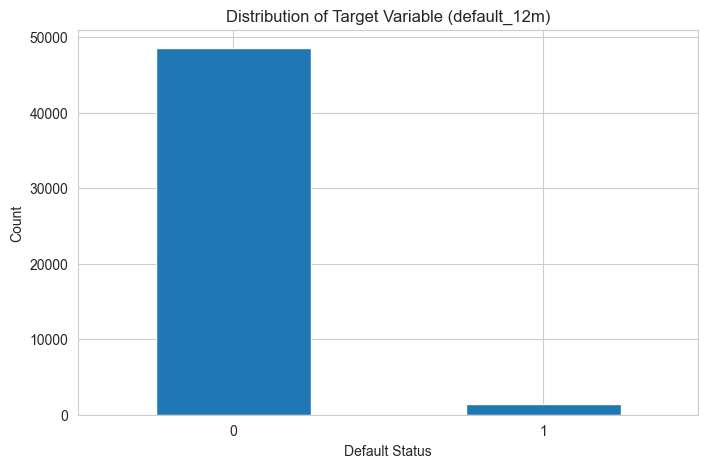

In [6]:
# Target variable distribution
print(f"Default Rate: {df['default_12m'].mean():.2%}")
print(f"\nClass Distribution:")
print(df['default_12m'].value_counts())

# Visualize
plt.figure(figsize=(8, 5))
df['default_12m'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable (default_12m)')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### 2.2 Feature Analysis

TODO: Add your EDA analysis here:
- Distribution plots for numerical features
- Correlation analysis
- Outlier detection
- Relationship between features and target variable
- Analysis of categorical variables


Numerical features: 16 | Categorical features: 5


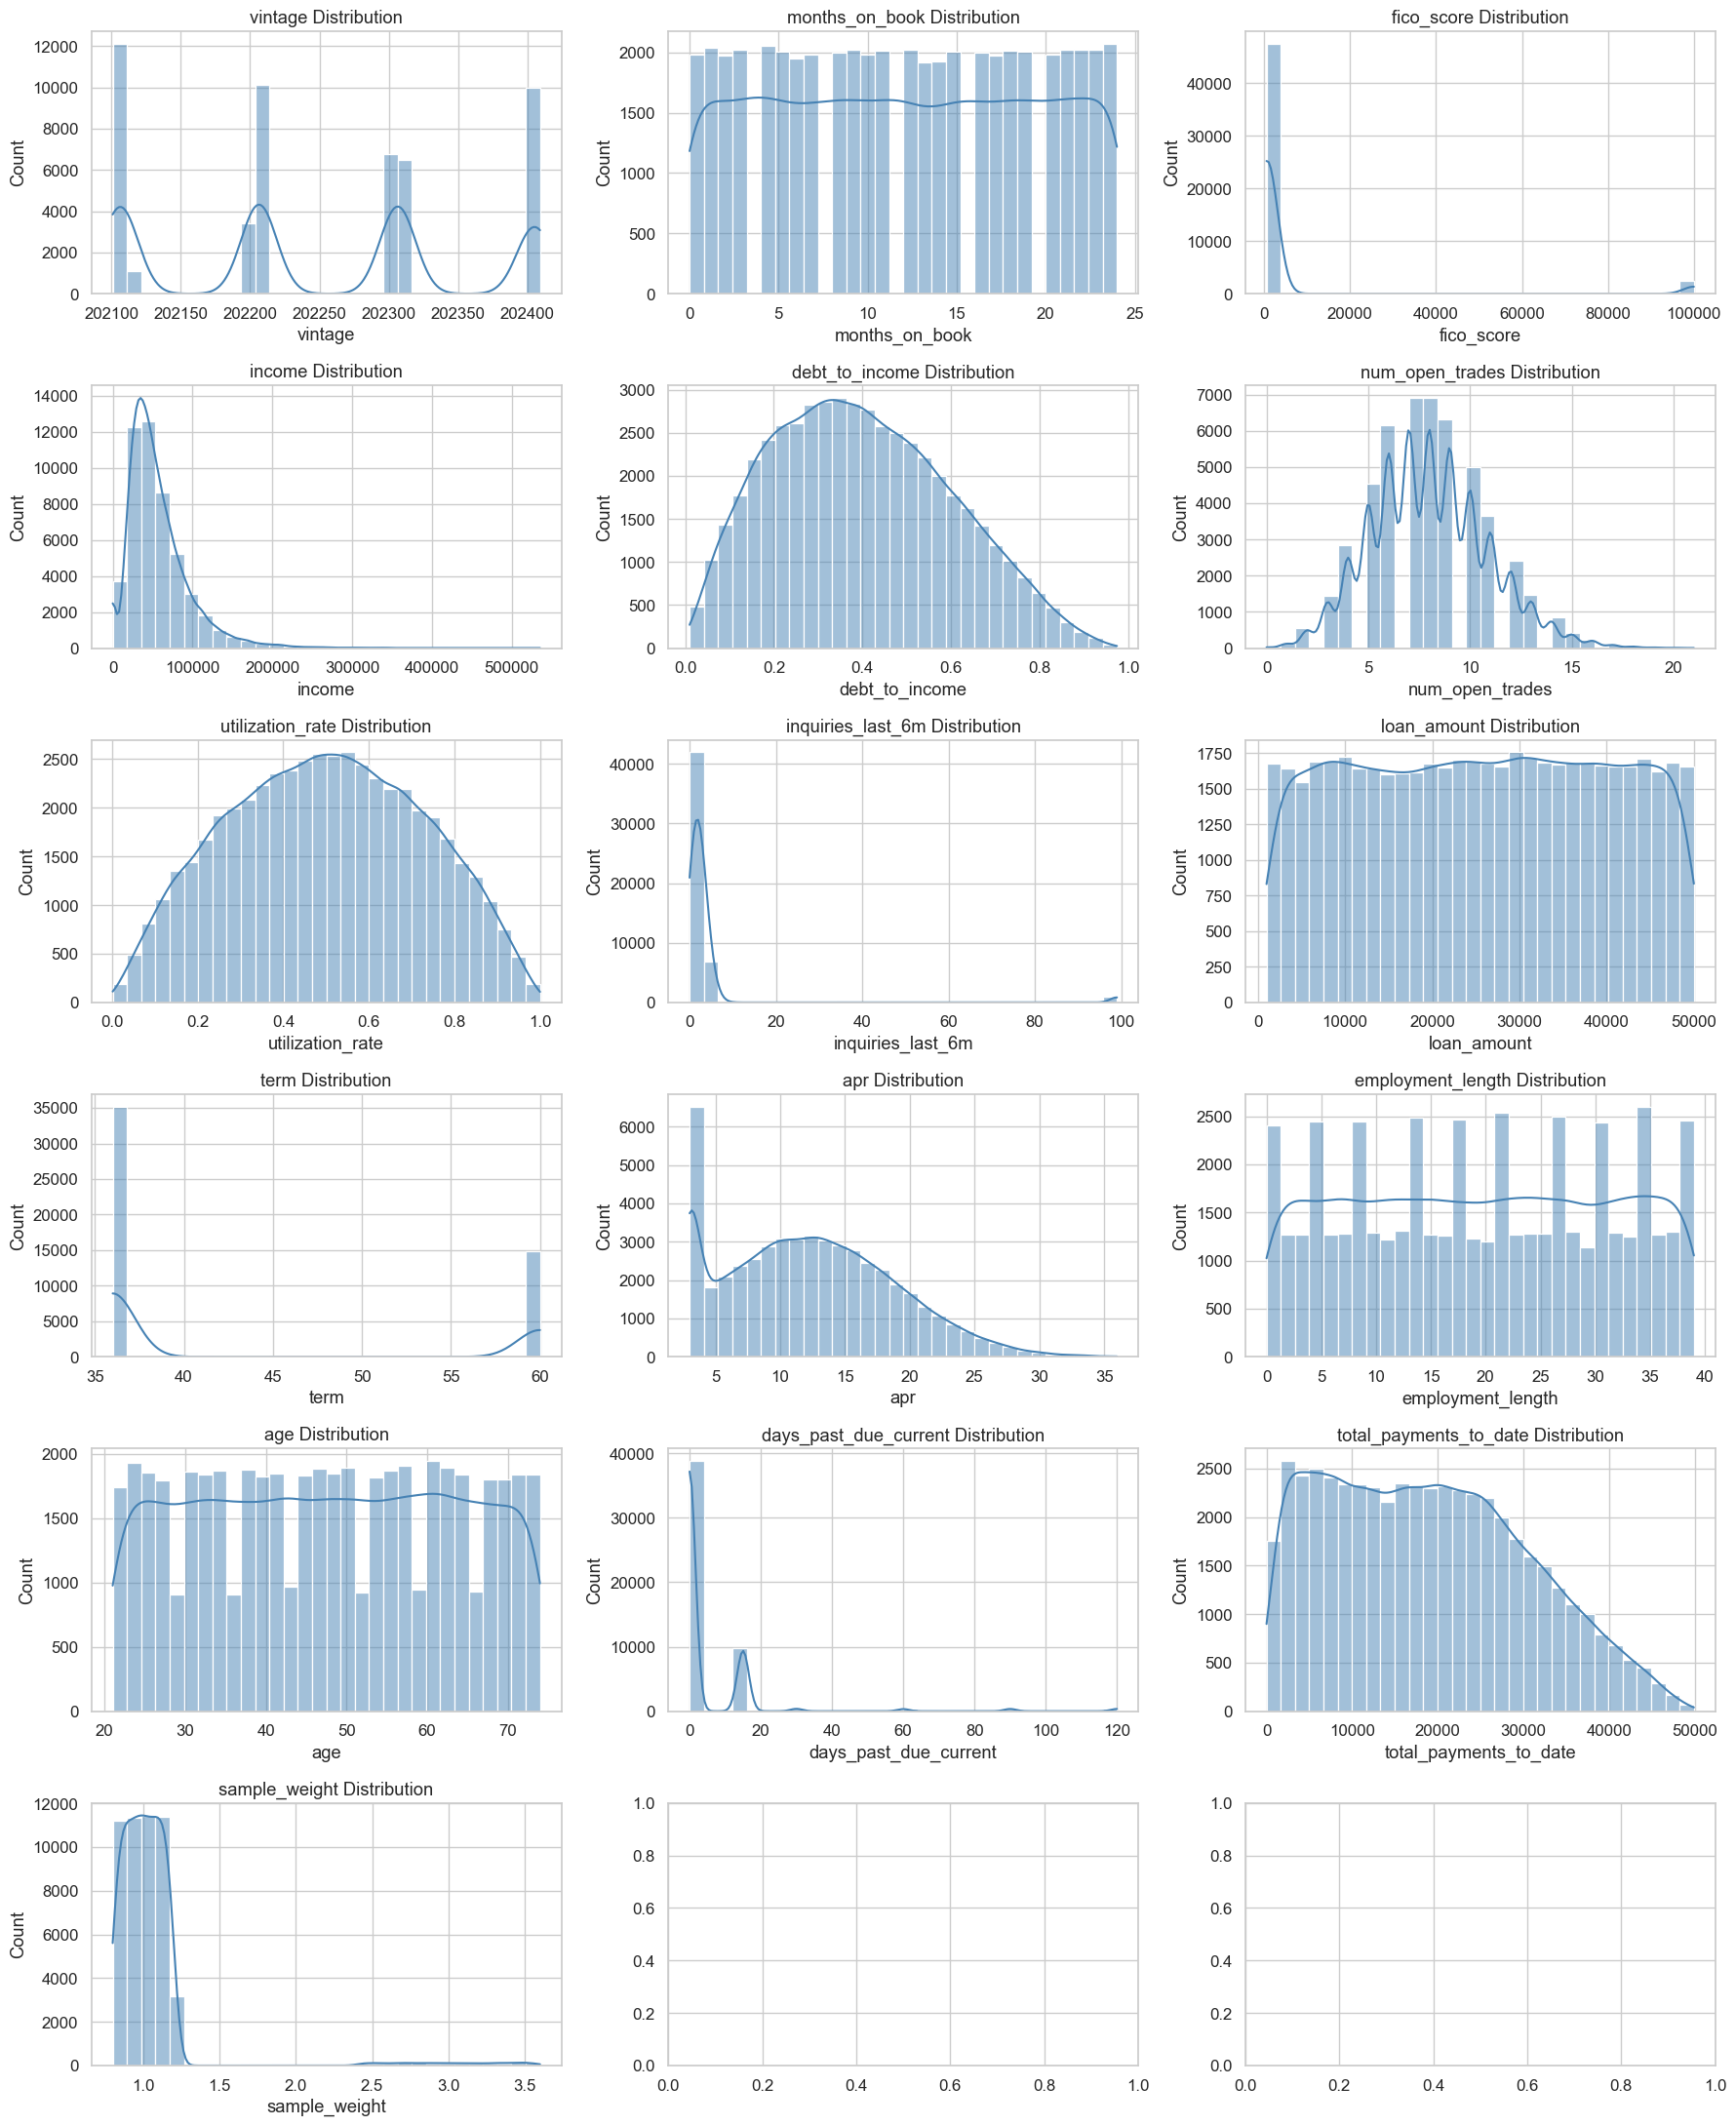

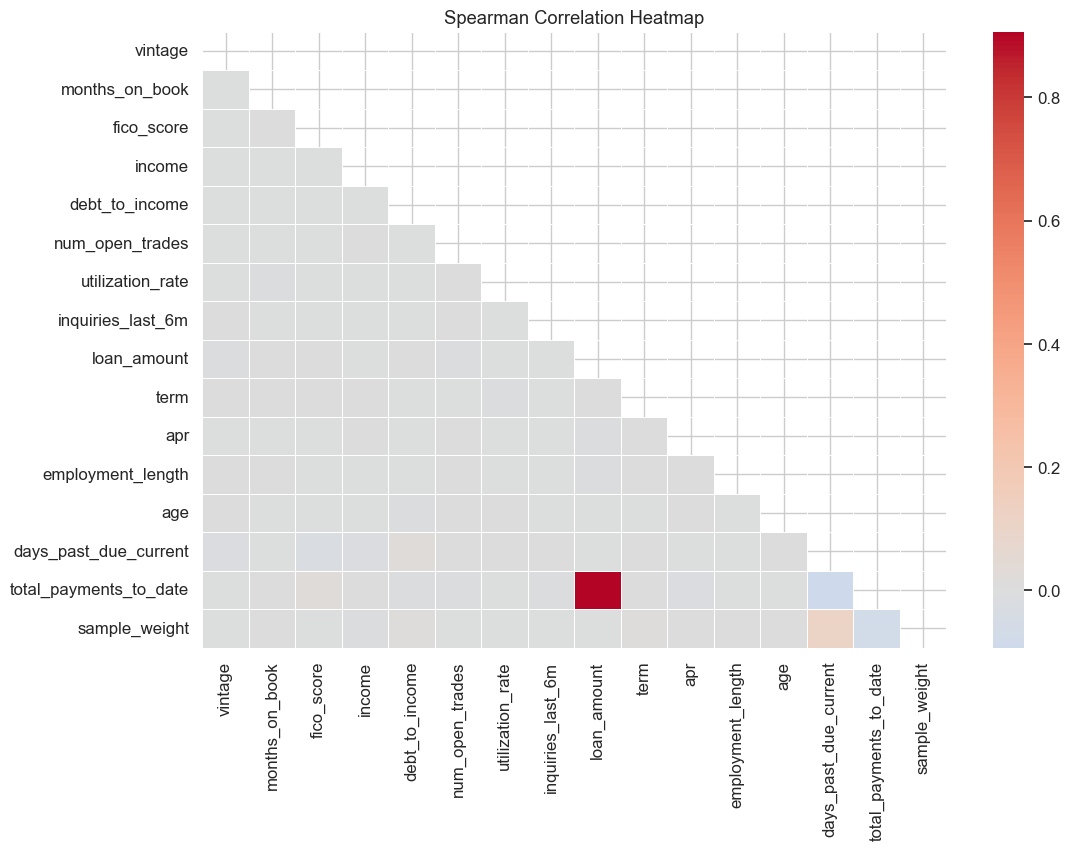


Top 10 features correlated with default_12m:
 sample_weight             0.933926
days_past_due_current     0.822525
total_payments_to_date   -0.221461
debt_to_income            0.053333
income                   -0.030145
inquiries_last_6m         0.028931
vintage                  -0.022006
utilization_rate          0.018140
fico_score                0.017740
term                     -0.004767
dtype: float64


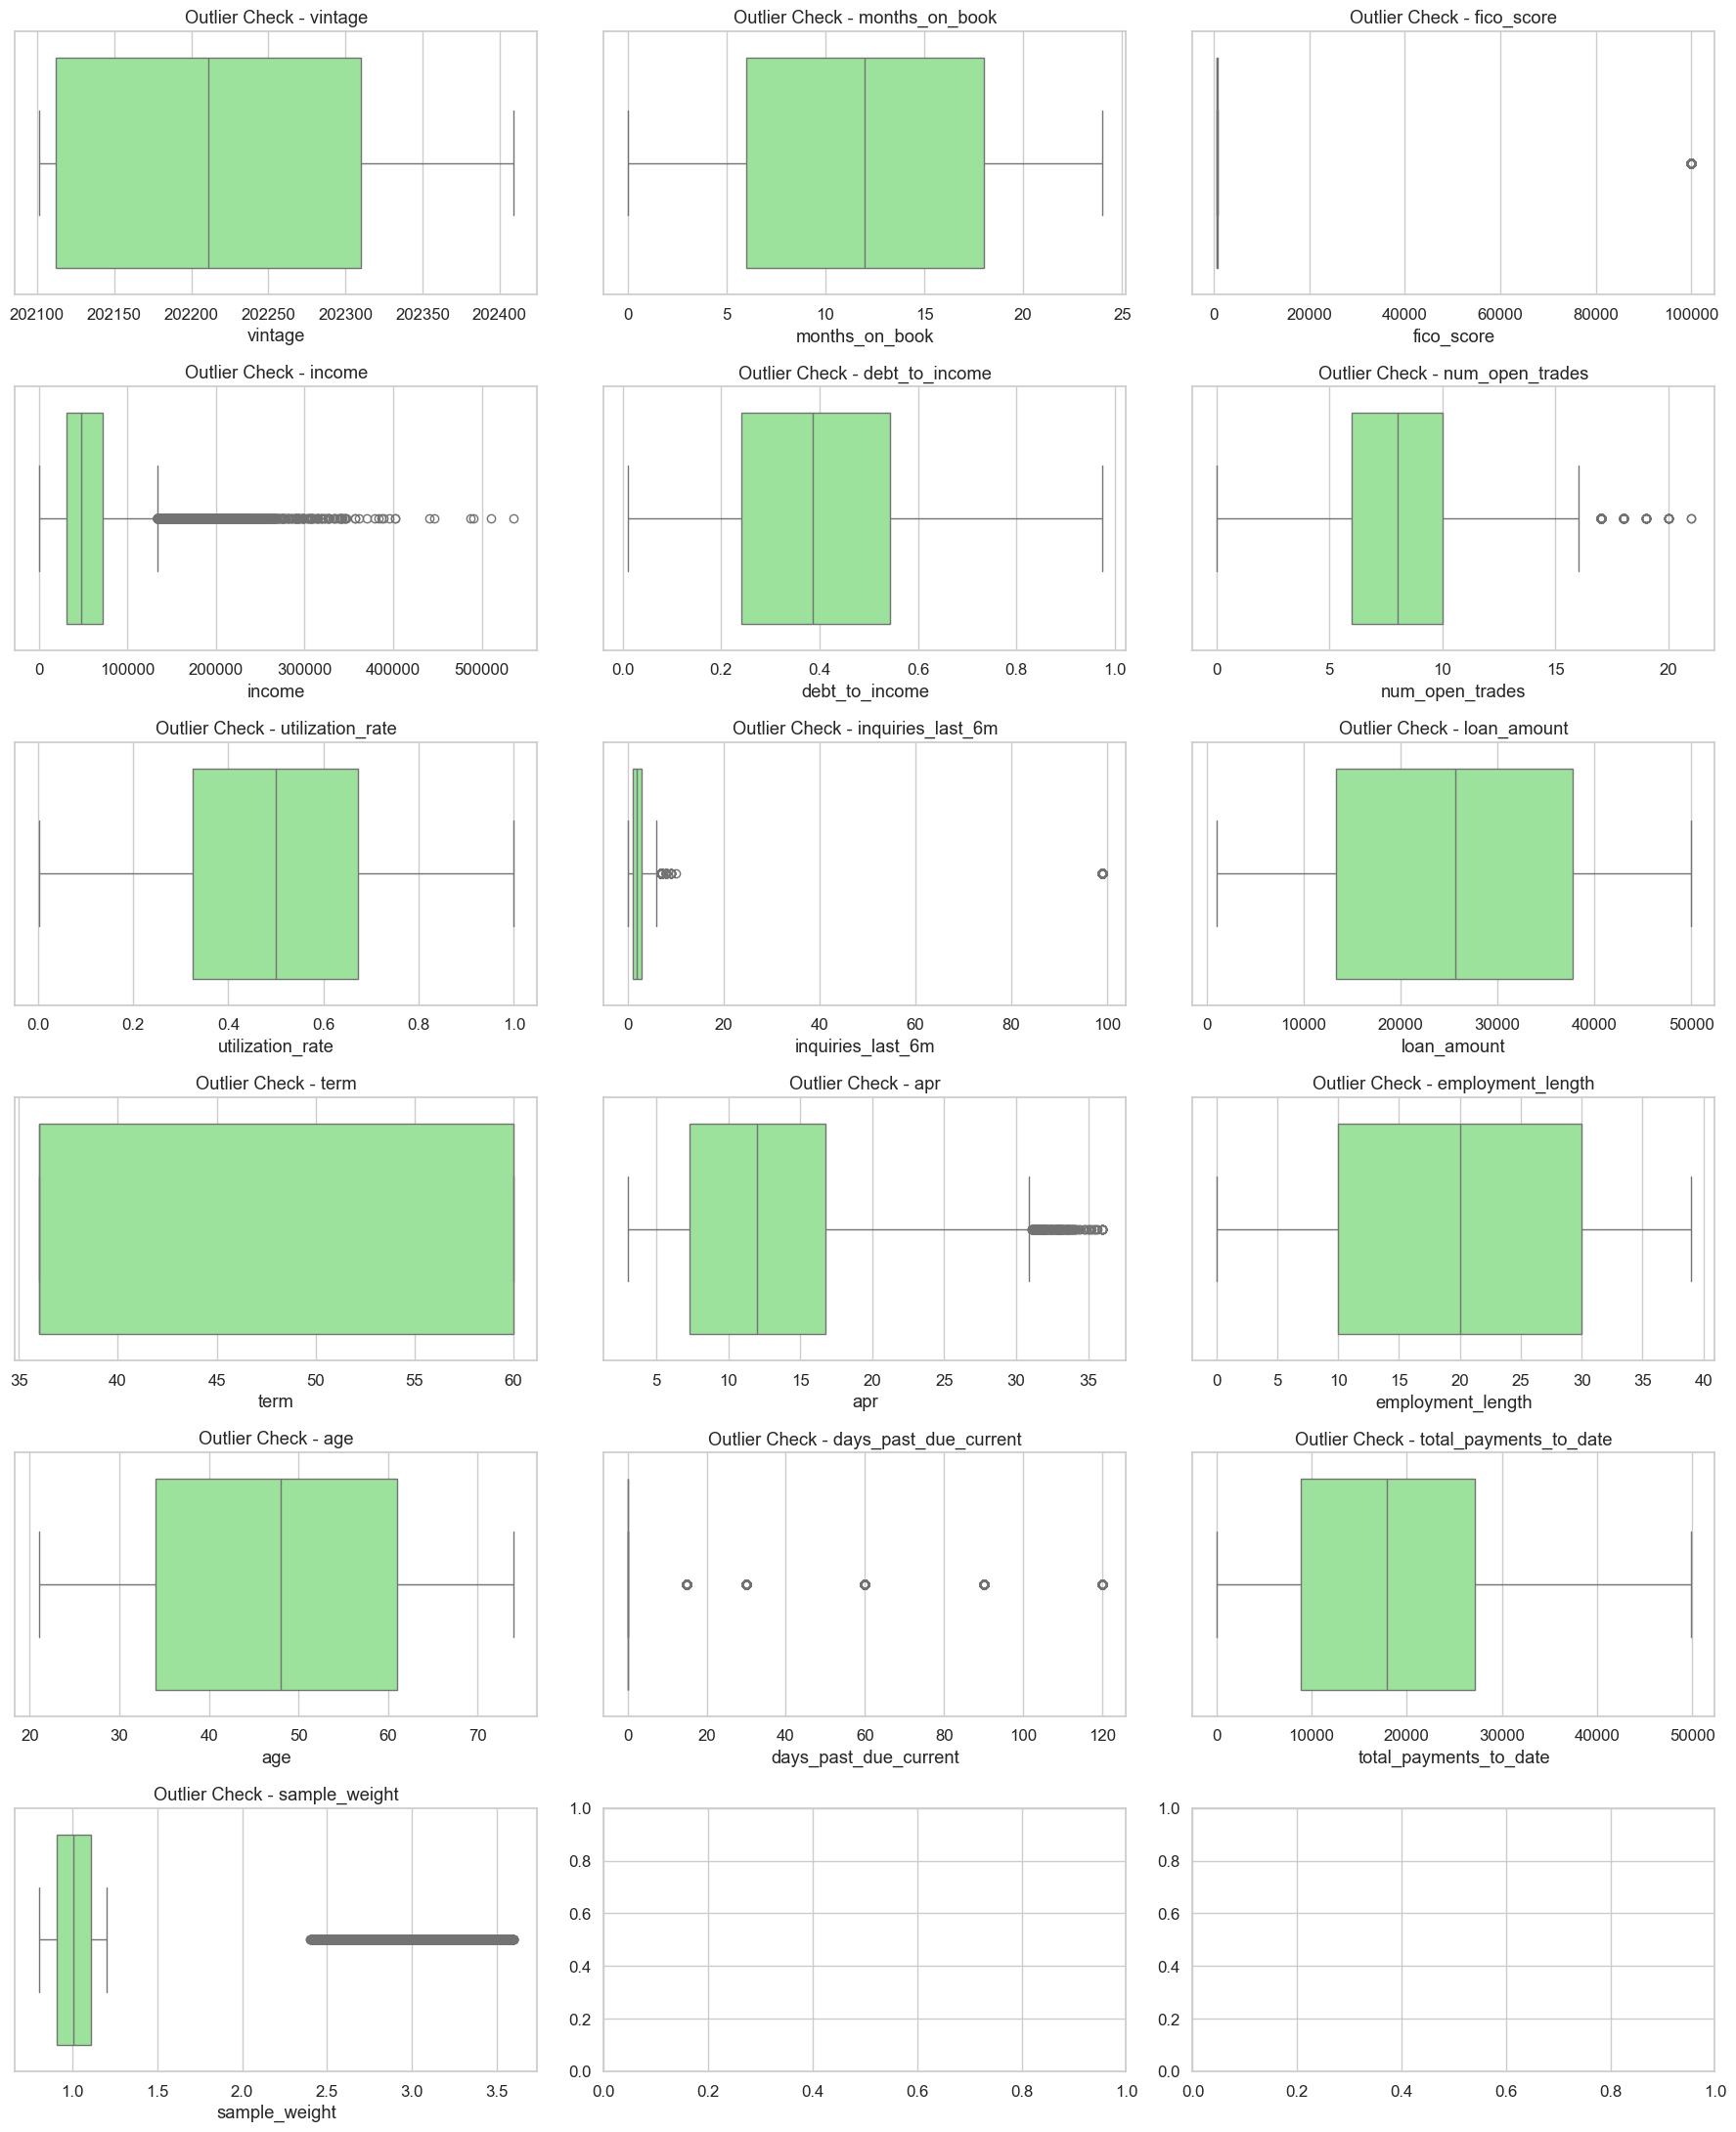

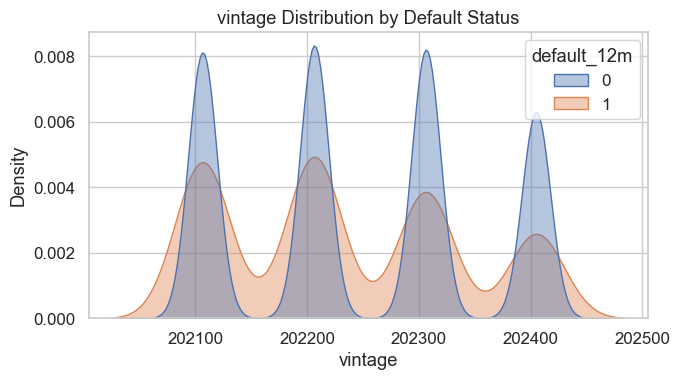

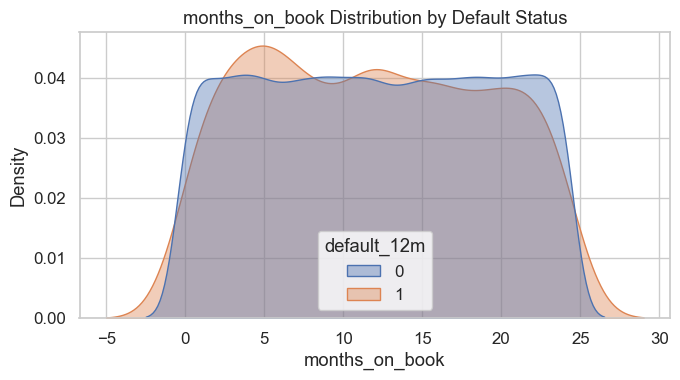

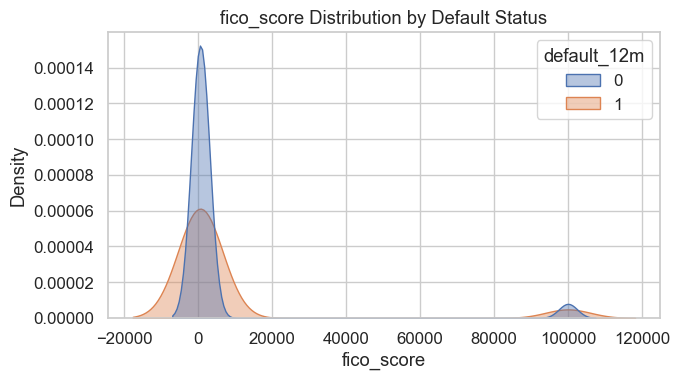

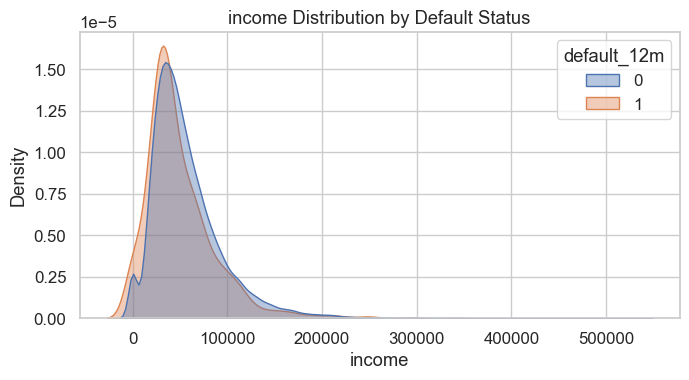

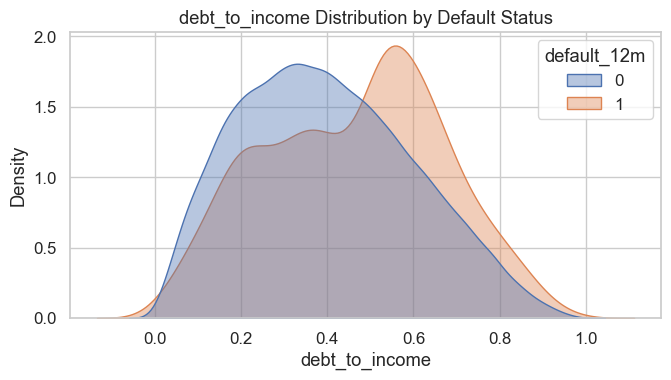

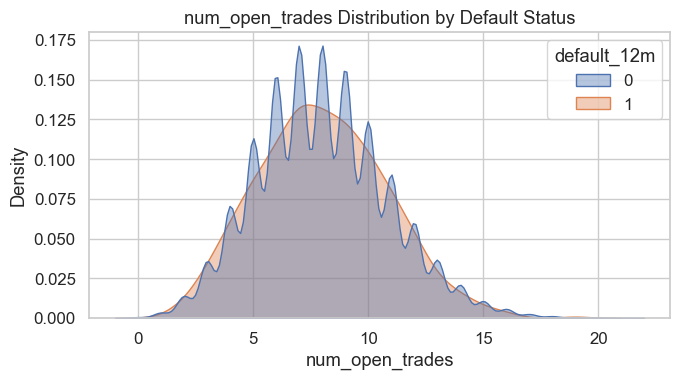

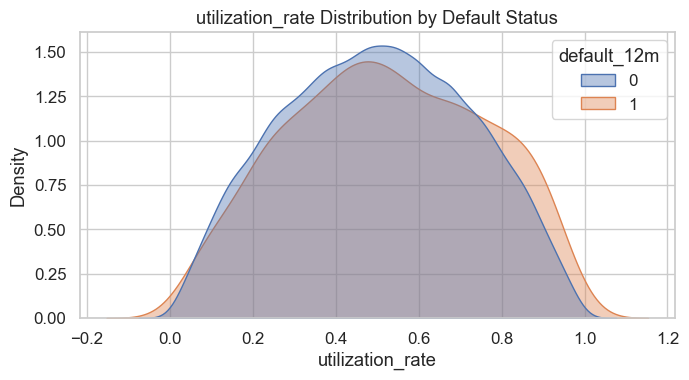

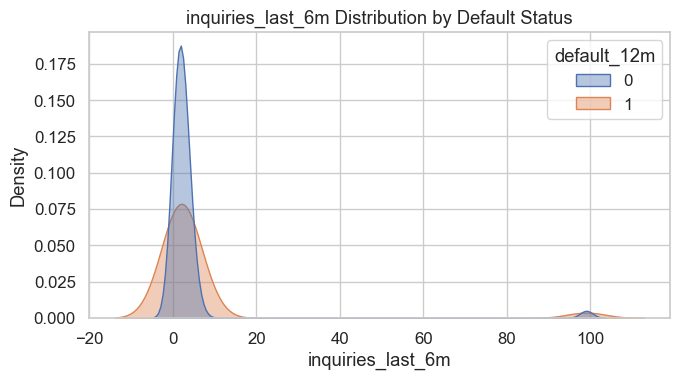

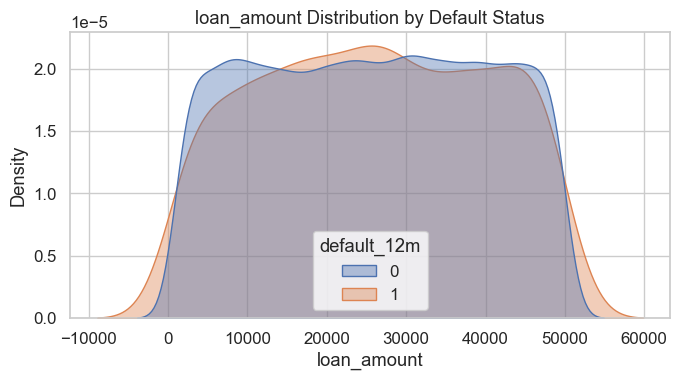

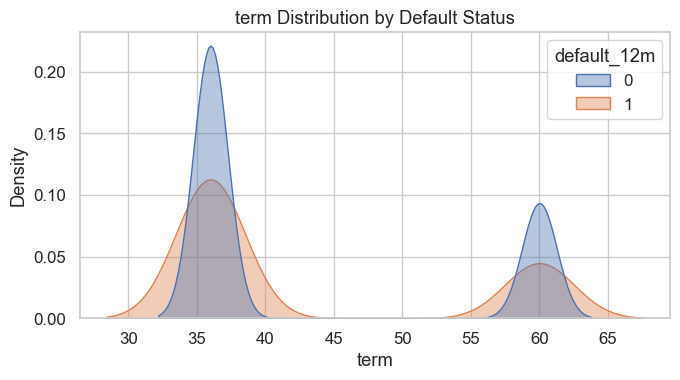

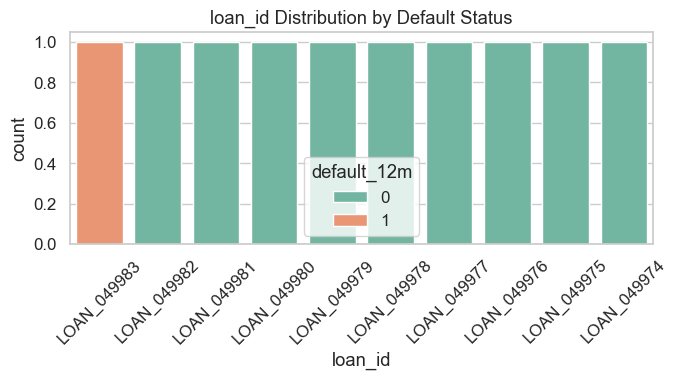

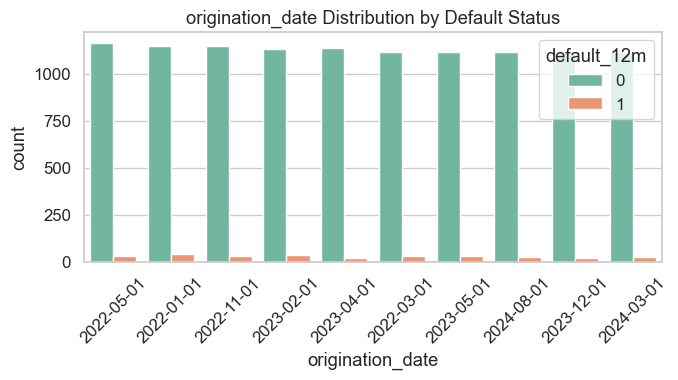

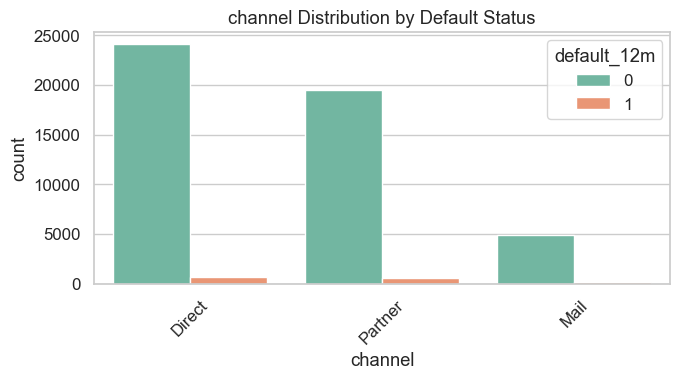

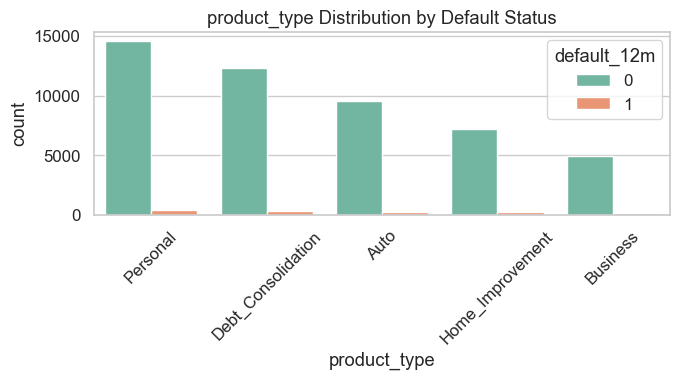

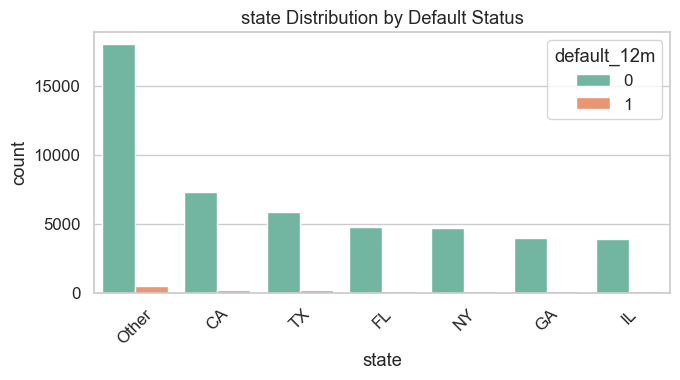

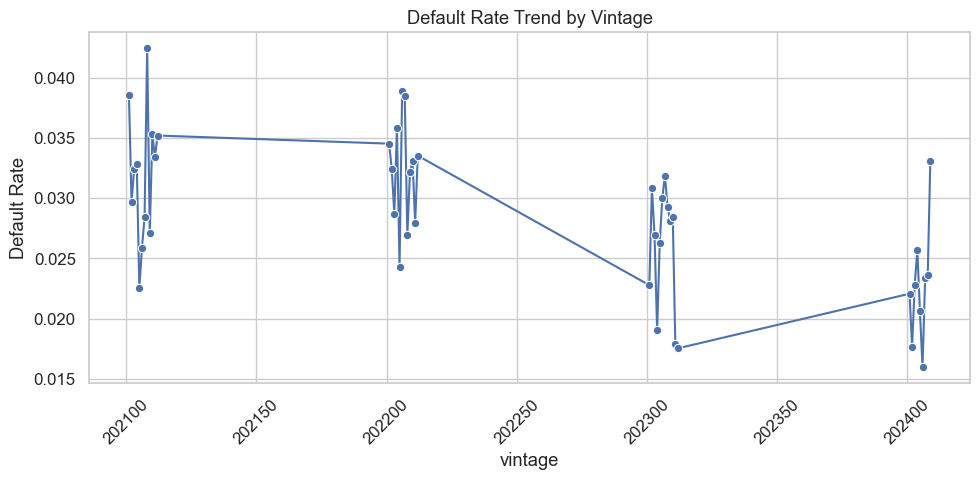

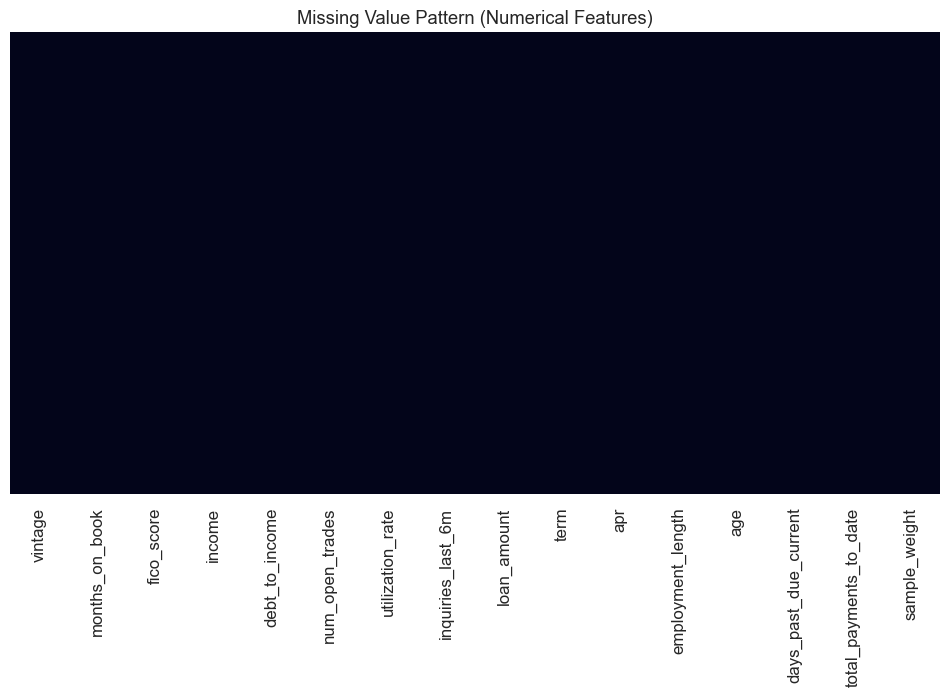

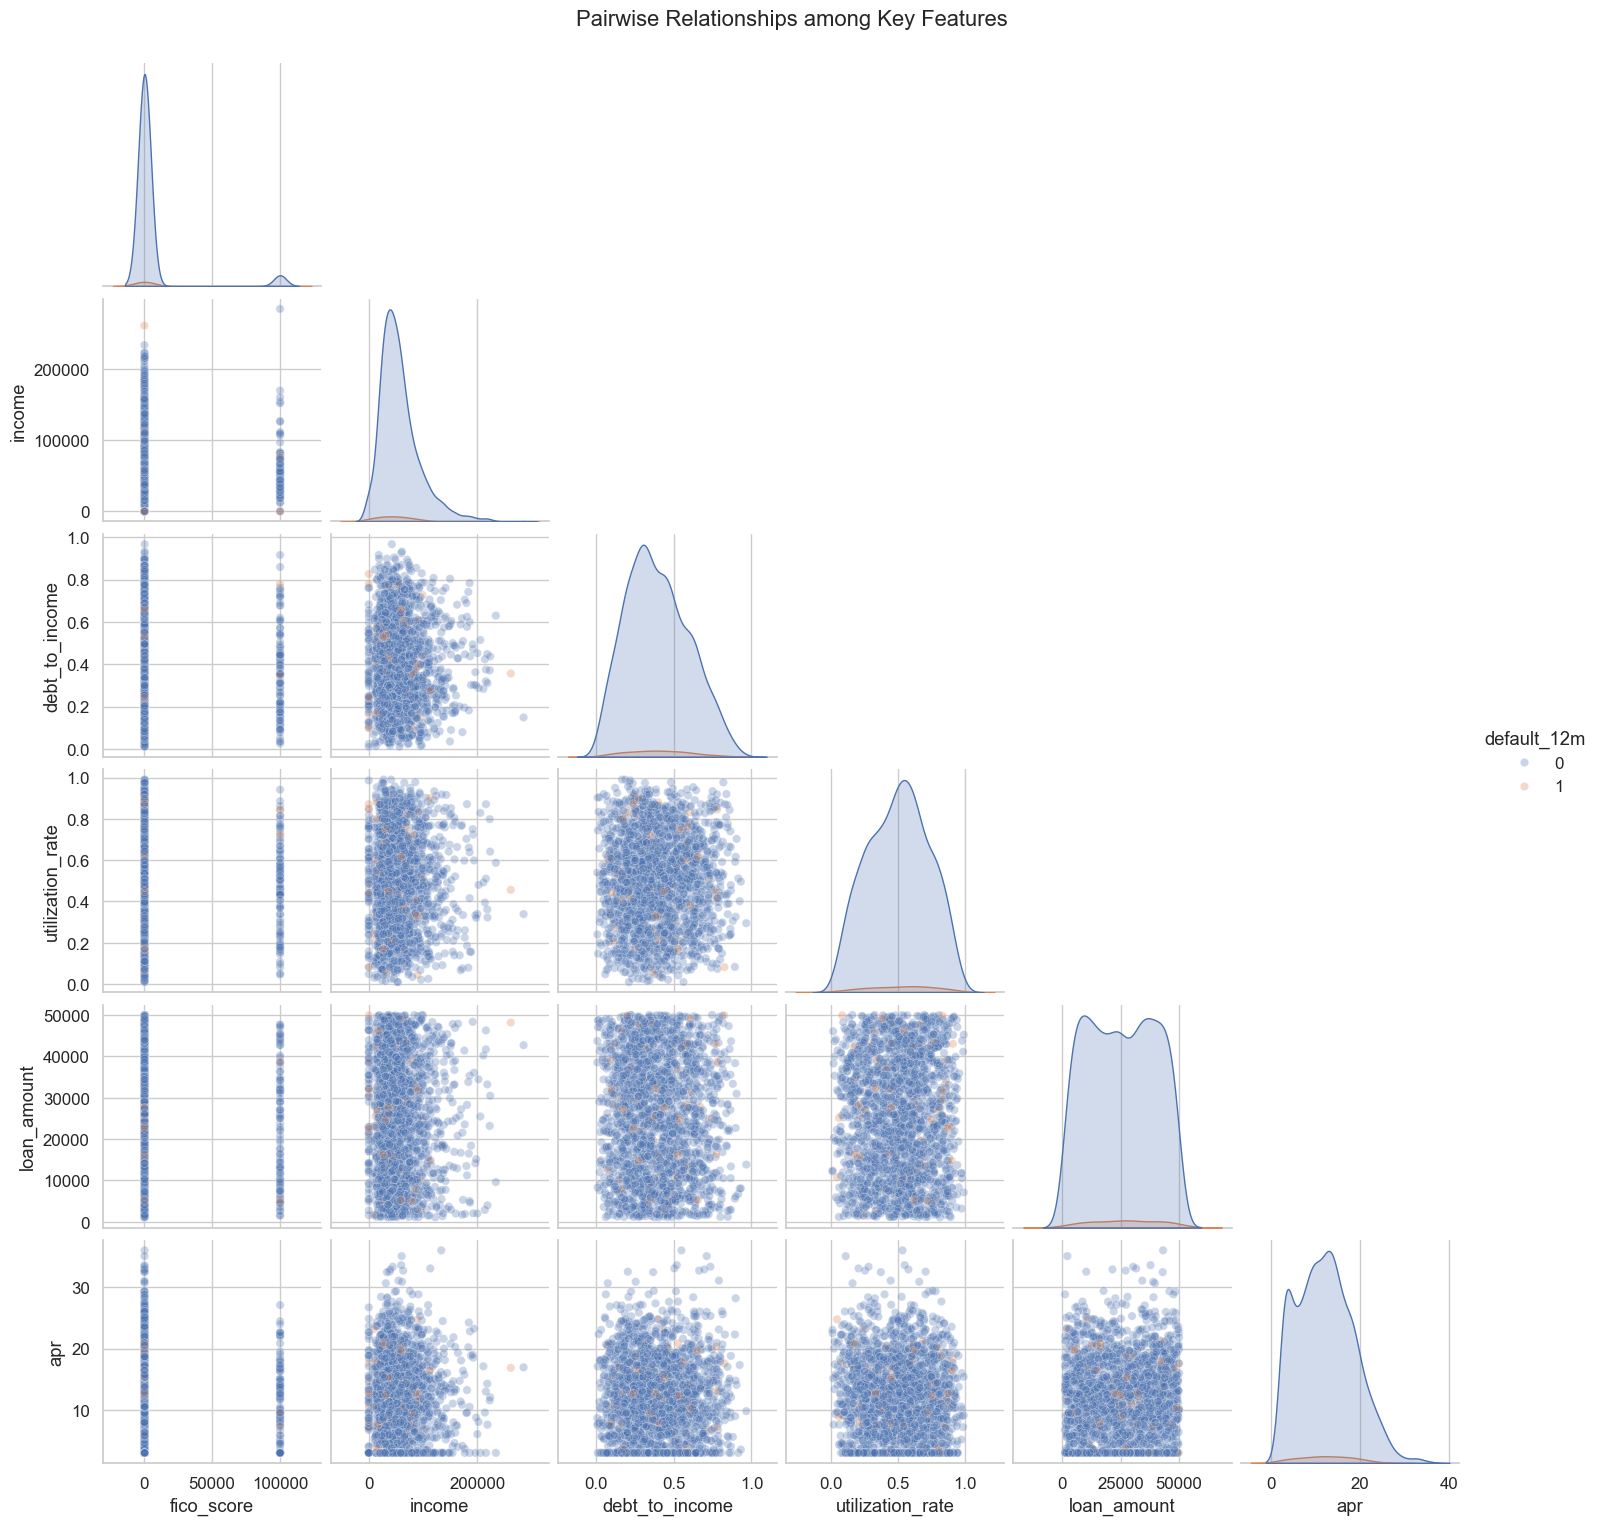

In [7]:
# Your EDA code here
# =========================================
# 2.2 FEATURE ANALYSIS (ADVANCED EDA)
# =========================================

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd

# Ensure consistent plotting style
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 5)

# -------------------------------
# 1. Identify feature groups
# -------------------------------
target_col = 'default_12m'
num_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col, errors='ignore')
cat_cols = df.select_dtypes(include=['object', 'category']).columns

print(f"Numerical features: {len(num_cols)} | Categorical features: {len(cat_cols)}")

# -------------------------------
# 2. Check numerical distributions
# -------------------------------
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 22))
axes = axes.flatten()

for i, col in enumerate(num_cols[:18]):  # limit first 18 numerical columns for clarity
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color='steelblue')
    axes[i].set_title(f"{col} Distribution")
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Correlation analysis
# -------------------------------
corr_matrix = df[num_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

# Top correlations with target
target_corr = corr_matrix[target_col] if target_col in corr_matrix.columns else df[num_cols].corrwith(df[target_col])
target_corr = target_corr.sort_values(key=abs, ascending=False)
print("\nTop 10 features correlated with default_12m:\n", target_corr.head(10))

# -------------------------------
# 4. Outlier detection (boxplots)
# -------------------------------
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 22))
axes = axes.flatten()

for i, col in enumerate(num_cols[:18]):
    sns.boxplot(x=df[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(f"Outlier Check - {col}")
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Relationship with target
# -------------------------------
for col in num_cols[:10]:
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)
    plt.title(f"{col} Distribution by Default Status")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6. Categorical feature analysis
# -------------------------------
for col in cat_cols:
    plt.figure(figsize=(7, 4))
    order = df[col].value_counts().index[:10]  # top categories only
    sns.countplot(data=df, x=col, hue=target_col, order=order, palette="Set2")
    plt.title(f"{col} Distribution by Default Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 7. Temporal pattern (vintage-based default rates)
# -------------------------------
if 'vintage' in df.columns:
    vintage_defaults = df.groupby('vintage')[target_col].mean().reset_index()
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=vintage_defaults, x='vintage', y=target_col, marker='o')
    plt.title("Default Rate Trend by Vintage")
    plt.xticks(rotation=45)
    plt.ylabel("Default Rate")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 8. Missing value pattern heatmap
# -------------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(df[num_cols].isna(), cbar=False, yticklabels=False)
plt.title("Missing Value Pattern (Numerical Features)")
plt.show()

# -------------------------------
# 9. Pairwise relationships (optional sampling)
# -------------------------------
sample_df = df.sample(min(2000, len(df)), random_state=42)
pair_cols = [c for c in num_cols if c in ['fico_score', 'income', 'debt_to_income', 'loan_amount', 'apr', 'utilization_rate']]
sns.pairplot(sample_df, vars=pair_cols, hue=target_col, diag_kind='kde', corner=True, plot_kws={'alpha':0.3})
plt.suptitle("Pairwise Relationships among Key Features", y=1.02)
plt.show()



## 3. Data Preprocessing & Feature Engineering

### 3.1 Handle Missing Values


Missing values before cleaning:
 Series([], dtype: int64)

Missing values after cleaning:
 Series([], dtype: int64)


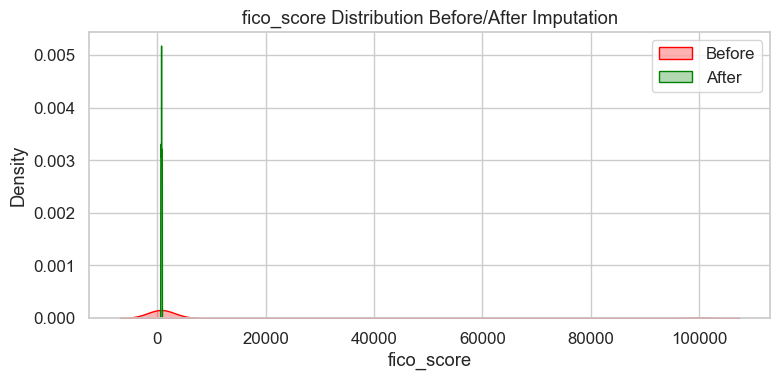

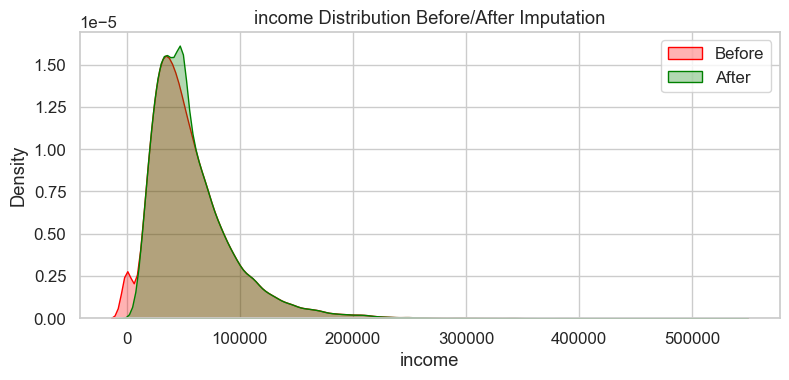

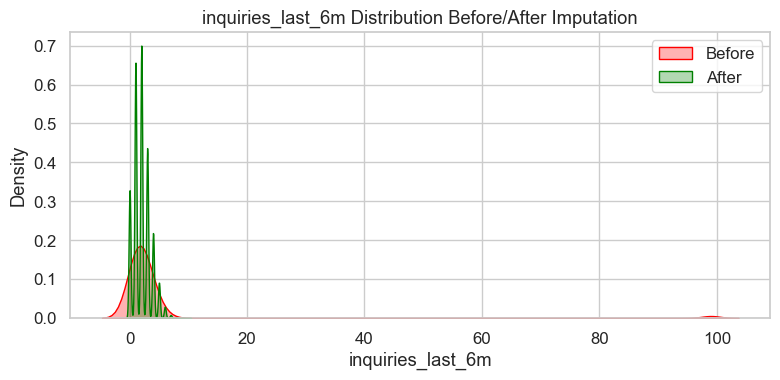


Data shape after missing-value handling: (50000, 25)


In [8]:
# Your preprocessing code here
# =========================================
# 3.1 HANDLE MISSING VALUES
# =========================================

from src.preprocessing import handle_missing_values

# Display missing stats before cleaning
missing_summary = df.isna().sum()
print("Missing values before cleaning:\n", missing_summary[missing_summary > 0])

# Apply missing value handling
df_clean = handle_missing_values(df, strategy='median')

# Verify after cleaning
missing_after = df_clean.isna().sum()
print("\nMissing values after cleaning:\n", missing_after[missing_after > 0])

# Compare distributions before and after cleaning
import matplotlib.pyplot as plt
import seaborn as sns

check_cols = ['fico_score', 'income', 'inquiries_last_6m']
for col in check_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(df[col], label='Before', color='red', fill=True, alpha=0.3)
        sns.kdeplot(df_clean[col], label='After', color='green', fill=True, alpha=0.3)
        plt.title(f"{col} Distribution Before/After Imputation")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Keep cleaned version for next steps
df = df_clean.copy()
print(f"\nData shape after missing-value handling: {df.shape}")


### 3.2 Handle Outliers


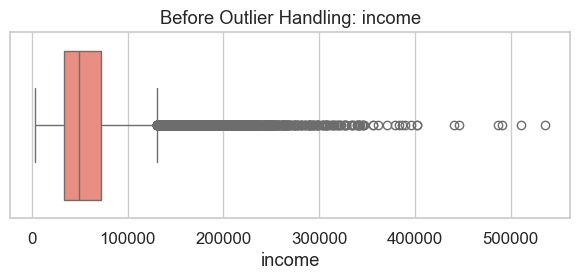

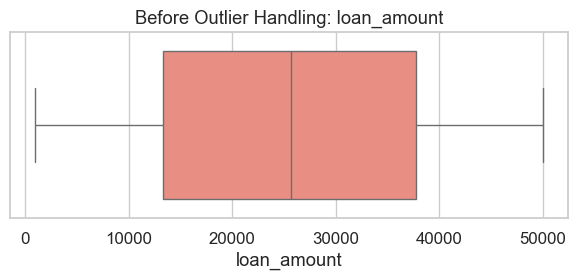

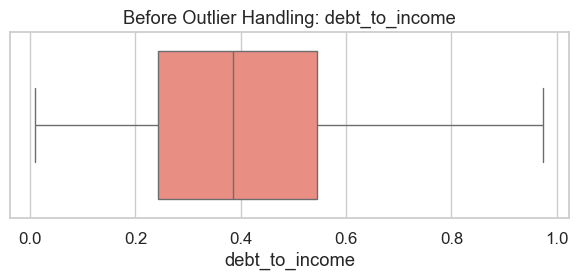

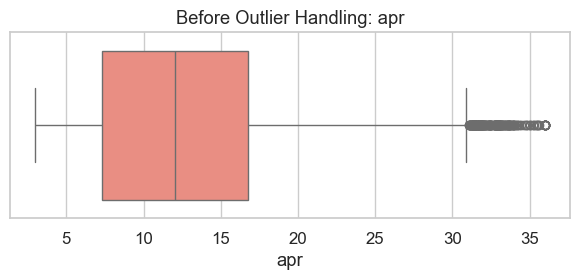

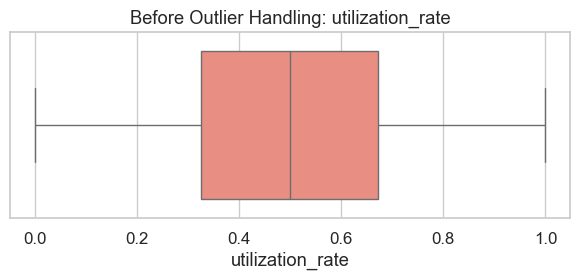

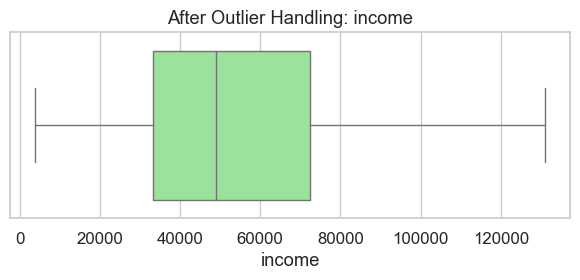

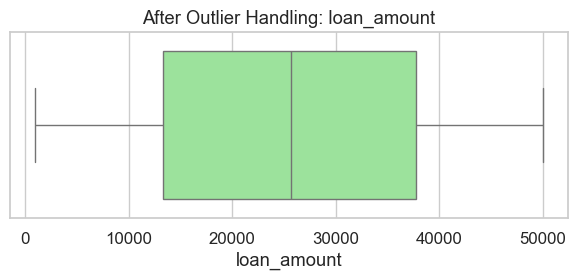

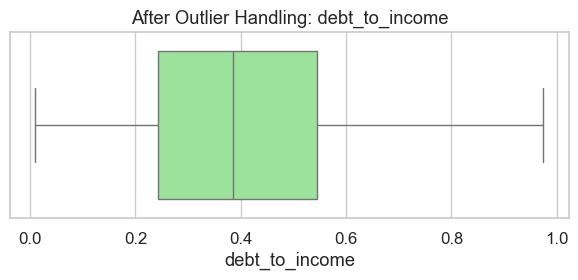

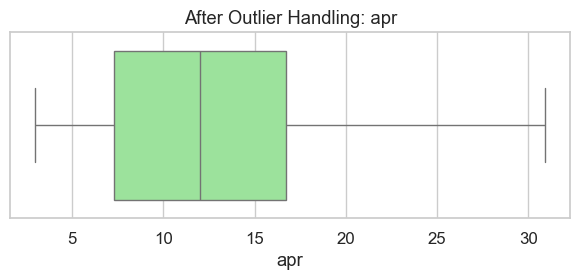

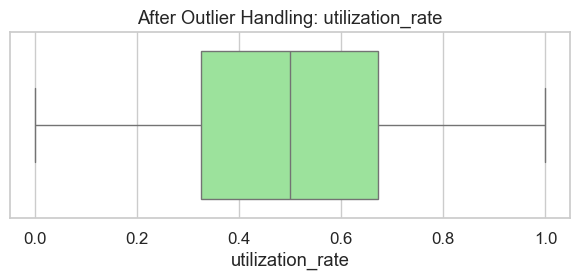


Statistical comparison before vs after outlier handling:

                  mean_before  std_before  min_before  max_before  mean_after  \
income               58335.43    37683.12     3947.00   535593.00    56318.20   
loan_amount          25581.60    14113.52     1000.00    49998.00    25581.60   
debt_to_income           0.40        0.20        0.01        0.97        0.40   
apr                     12.33        6.41        3.00       35.99       12.33   
utilization_rate         0.50        0.22        0.00        1.00        0.50   

                  std_after  min_after  max_after  
income             30644.35    3947.00  130991.62  
loan_amount        14113.52    1000.00   49998.00  
debt_to_income         0.20       0.01       0.97  
apr                    6.39       3.00      30.90  
utilization_rate       0.22       0.00       1.00  

Data shape after outlier handling: (50000, 25)


In [9]:
# Your outlier handling code here
# =========================================
# 3.2 HANDLE OUTLIERS
# =========================================

from src.preprocessing import handle_outliers

# Visualize before handling
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = df.select_dtypes(include=['number']).columns
sample_features = ['income', 'loan_amount', 'debt_to_income', 'apr', 'utilization_rate']

for col in sample_features:
    if col in numeric_features:
        plt.figure(figsize=(6, 3))
        sns.boxplot(x=df[col], color='salmon')
        plt.title(f"Before Outlier Handling: {col}")
        plt.tight_layout()
        plt.show()

# Apply outlier handling (IQR capping)
df_out = handle_outliers(df, method='iqr')

# Compare after capping
for col in sample_features:
    if col in numeric_features:
        plt.figure(figsize=(6, 3))
        sns.boxplot(x=df_out[col], color='lightgreen')
        plt.title(f"After Outlier Handling: {col}")
        plt.tight_layout()
        plt.show()

# Summary of distribution shifts
summary_before = df[sample_features].describe().T[['mean', 'std', 'min', 'max']]
summary_after = df_out[sample_features].describe().T[['mean', 'std', 'min', 'max']]
comparison = summary_before.join(summary_after, lsuffix='_before', rsuffix='_after')
print("\nStatistical comparison before vs after outlier handling:\n")
print(comparison.round(2))

# Keep cleaned dataset
df = df_out.copy()
print(f"\nData shape after outlier handling: {df.shape}")


### 3.3 Feature Engineering


Original shape: (50000, 25)
New shape after feature engineering: (50000, 34)

Newly engineered features:
 ['income_to_loan_ratio', 'debt_utilization_interaction', 'apr_to_fico_ratio', 'employment_to_term_ratio', 'log_income', 'log_loan_amount', 'is_senior', 'age_bucket', 'is_online_channel']


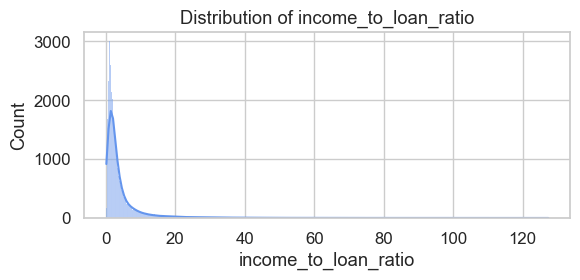

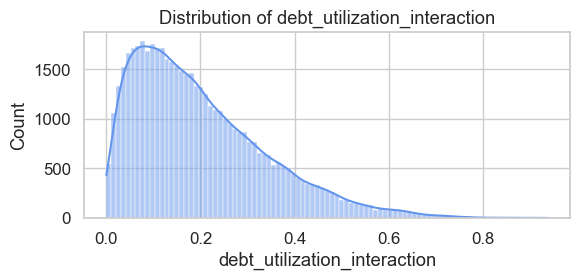

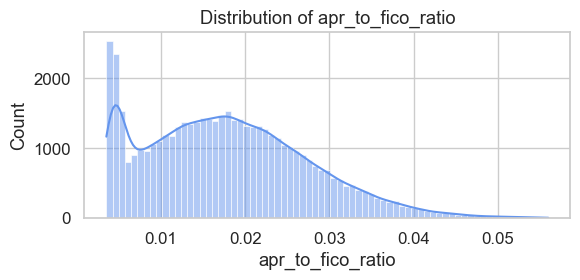

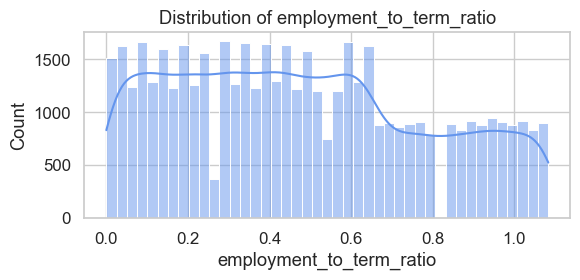

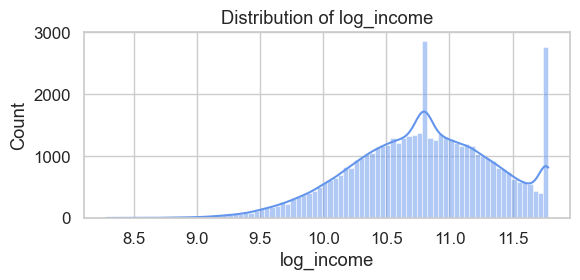

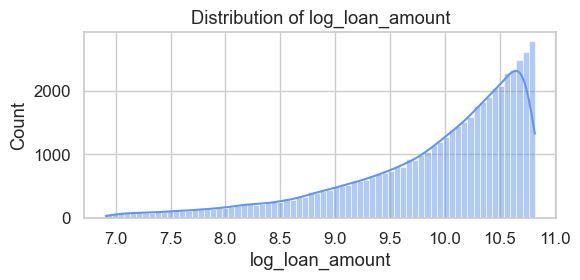


Correlation of engineered numeric features with target:
 debt_utilization_interaction    0.051297
log_income                     -0.031866
apr_to_fico_ratio               0.018146
income_to_loan_ratio           -0.007400
is_senior                       0.002177
log_loan_amount                 0.001494
employment_to_term_ratio       -0.000421
is_online_channel                    NaN
dtype: float64


In [10]:
# Your feature engineering code here
# =========================================
# 3.3 FEATURE ENGINEERING
# =========================================

from src.preprocessing import create_features

# Apply feature engineering
df_fe = create_features(df)

print(f"Original shape: {df.shape}")
print(f"New shape after feature engineering: {df_fe.shape}")

# Identify new columns
new_cols = [c for c in df_fe.columns if c not in df.columns]
print("\nNewly engineered features:\n", new_cols)

# Quick inspection of new features
import seaborn as sns
import matplotlib.pyplot as plt

sample_features = ['income_to_loan_ratio', 'debt_utilization_interaction', 
                   'apr_to_fico_ratio', 'employment_to_term_ratio', 'log_income', 'log_loan_amount']

for col in sample_features:
    if col in df_fe.columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(df_fe[col], kde=True, color='cornflowerblue')
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

# Compute correlation only for numeric engineered features
numeric_new_cols = [c for c in new_cols if pd.api.types.is_numeric_dtype(df_fe[c])]
if numeric_new_cols:
    new_corr = df_fe[numeric_new_cols].corrwith(df_fe['default_12m']).sort_values(key=abs, ascending=False)
    print("\nCorrelation of engineered numeric features with target:\n", new_corr.head(10))
else:
    print("\nNo numeric engineered features available for correlation check.")

# Keep engineered dataset
df = df_fe.copy()


### 3.4 Encode Categorical Variables


In [11]:
# =========================================
# 3.4 ENCODE CATEGORICAL VARIABLES
# =========================================

from src.preprocessing import encode_categorical
import pandas as pd

# 1) Identify all categorical-like columns
raw_cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("All categorical-like columns:", raw_cat_cols)

# 2) Exclude ID / date / split-helper columns from encoding
exclude_cols = ['loan_id', 'origination_date']  # we'll keep 'vintage' for splitting later
cat_candidates = [c for c in raw_cat_cols if c not in exclude_cols]

print("Columns considered for encoding:", cat_candidates)

# 3) Inspect cardinality
cardinality = df[cat_candidates].nunique().sort_values(ascending=False)
print("\nCardinality of candidate categoricals:\n", cardinality)

# 4) Only one-hot encode low/medium-cardinality columns
max_onehot_categories = 50
oh_cols = [c for c in cat_candidates if cardinality[c] <= max_onehot_categories]

print("\nColumns to one-hot encode (<= 50 unique values):", oh_cols)

encoding_method = 'onehot'  # or 'label' / 'target' if you want later

df_encoded = encode_categorical(df, columns=oh_cols, method=encoding_method)

print(f"\nOriginal shape: {df.shape}")
print(f"Encoded shape: {df_encoded.shape}")

# Show a few encoded columns
encoded_preview = [c for c in df_encoded.columns if any(col + '_' in c for col in oh_cols)]
print("\nExample encoded columns:\n", encoded_preview[:10])

# 5) Verify no object/category types remain except allowed ones (e.g. vintage)
remaining_obj = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining non-numeric columns after encoding:", remaining_obj)

# 6) Use encoded df going forward (no extra .copy() to avoid massive extra allocation)
df = df_encoded

print(f"\nData shape after encoding step: {df.shape}")


All categorical-like columns: ['loan_id', 'origination_date', 'channel', 'product_type', 'state', 'age_bucket']
Columns considered for encoding: ['channel', 'product_type', 'state', 'age_bucket']

Cardinality of candidate categoricals:
 state           7
age_bucket      6
product_type    5
channel         3
dtype: int64

Columns to one-hot encode (<= 50 unique values): ['channel', 'product_type', 'state', 'age_bucket']
Encoding 4 categorical columns using 'onehot' method...

Original shape: (50000, 34)
Encoded shape: (50000, 47)

Example encoded columns:
 ['channel_Mail', 'channel_Partner', 'product_type_Business', 'product_type_Debt_Consolidation', 'product_type_Home_Improvement', 'product_type_Personal', 'state_FL', 'state_GA', 'state_IL', 'state_NY']

Remaining non-numeric columns after encoding: ['loan_id', 'origination_date']

Data shape after encoding step: (50000, 47)


### 3.5 Train/Test Split


In [12]:
# =========================================
# 3.5 TRAIN / VALIDATION / TEST SPLIT
# =========================================

from src.modeling import train_test_split_data

# --- Step 1: Define target and features ---
target_col = 'default_12m'
drop_cols = [
    'loan_id', 'origination_date', 'vintage',
    'months_on_book', 'days_past_due_current', 'total_payments_to_date'
]
feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]

X = df[feature_cols]
y = df[target_col]

# --- Step 2: Perform split ---
X_train, X_valid, X_test, y_train, y_valid, y_test = train_test_split_data(
    X, y, test_size=0.2, val_size=0.2, random_state=42
)

# --- Step 3: Verify results ---
print(f"\nFeature count: {len(feature_cols)}")
print(f"Shapes -> Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")



✅ Random Train/Validation/Test Split Complete
Train size: 32,000
Valid size: 8,000
Test  size: 10,000
Default rate - Train: 2.85% | Valid: 2.85% | Test: 2.85%

Feature count: 40
Shapes -> Train: (32000, 40), Valid: (8000, 40), Test: (10000, 40)


## 4. Model Training

### 4.1 Model 1: Logistic Regression


In [21]:
# =========================================
# 4.1 MODEL 1: LOGISTIC REGRESSION (LEAKAGE-SAFE)
# =========================================

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve
)
from src.modeling import train_logistic_regression, train_gradient_boosting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# LEAKAGE CHECK & FEATURE CLEANUP
# --- Step 1: Correlation check to spot leakage ---
corrs = df.corr(numeric_only=True)['default_12m'].sort_values(ascending=False)
print("Top correlated features with target:\n", corrs.head(10), "\n")

# --- Step 2: Drop known leakage columns ---
leakage_cols = [
    "days_past_due_current",
    "months_on_book",
    "total_payments_to_date",
    "loan_status",
    "sample_weight",
    "recent_delinquency_flag",
]
df = df.drop(columns=[c for c in leakage_cols if c in df.columns], errors="ignore")

# --- Step 3: Define feature set ---
drop_cols = ['loan_id', 'origination_date', 'vintage', 'default_12m']
feature_cols = [c for c in df.columns if c not in drop_cols]

# Align train/valid/test feature sets
X_train = X_train[feature_cols].copy()
X_valid = X_valid[feature_cols].copy()
X_test  = X_test[feature_cols].copy()

print(f"✅ Features after leakage removal: {len(feature_cols)} columns\n")

# Logistic Regression
log_reg_model = train_logistic_regression(X_train, y_train)

# --- Step 4: Validate model ---
y_valid_prob_lr = log_reg_model.predict_proba(X_valid)[:, 1]
roc_auc_lr = roc_auc_score(y_valid, y_valid_prob_lr)

print(f"\n✅ Logistic Regression trained successfully.")
print(f"Validation ROC-AUC: {roc_auc_lr:.4f}")

Top correlated features with target:
 default_12m                      1.000000
debt_to_income                   0.053333
debt_utilization_interaction     0.051297
apr_to_fico_ratio                0.018146
utilization_rate                 0.018140
inquiries_last_6m                0.011270
age_bucket_70+                   0.007398
state_GA                         0.006798
product_type_Home_Improvement    0.006164
state_FL                         0.004915
Name: default_12m, dtype: float64 

✅ Features after leakage removal: 39 columns


✅ Logistic Regression model successfully trained (leakage-safe).
Parameters: {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs', 'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}

✅ Logistic Regression trained successfully.
Validation ROC-AUC: 0.6351


### 4.2 Model 2: Gradient Boosting / XGBoost / LightGBM


In [22]:
# =========================================
# 4.2 MODEL 2: GRADIENT BOOSTING / XGBOOST (IMBALANCE-AWARE)
# =========================================

gb_model, model_type = train_gradient_boosting(X_train, y_train)

# --- Step 1: Validation prediction probabilities ---
y_valid_prob_gb = gb_model.predict_proba(X_valid)[:, 1]

# --- Step 2: Find best threshold for F1 optimization ---
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_valid_prob_gb)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"\n📉 Best threshold for F1 optimization: {best_thresh:.2f}")
print(f"Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

roc_auc_gb = roc_auc_score(y_valid, y_valid_prob_gb)
print(f"\n✅ Gradient Boosting ({model_type}) trained successfully.")
print(f"Validation ROC-AUC: {roc_auc_gb:.4f}")


⚖️  Class imbalance ratio (neg/pos): 34.0

✅ Gradient Boosting model (xgboost) successfully trained.
Parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': np.float64(34.049288061336256)}

📉 Best threshold for F1 optimization: 0.54
Precision: 0.058, Recall: 0.211, F1: 0.091

✅ Gradient Boosting (xgboost) trained successfully.
Validation ROC-AUC: 0.6390


## 5. Model Evaluation & Comparison

### 5.1 Calculate Metrics (AUC, KS, Precision-Recall)


In [23]:
# Calculate and compare metrics
from src.evaluation import (
    calculate_model_metrics,
    plot_roc_curve,
    plot_precision_recall_curve,
    evaluate_model
)

# ---------------------------------------------------------
# 5.1 CALCULATE METRICS (AUC, KS, PRECISION–RECALL)
# ---------------------------------------------------------

metrics_lr = calculate_model_metrics(y_valid, y_valid_prob_lr)
metrics_gb = calculate_model_metrics(y_valid, y_valid_prob_gb)

metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Gradient Boosting (XGBoost)"],
    "AUC": [metrics_lr["AUC"], metrics_gb["AUC"]],
    "KS": [metrics_lr["KS"], metrics_gb["KS"]],
    "PR-AUC": [metrics_lr["PR-AUC"], metrics_gb["PR-AUC"]],
})

print("\n✅ Validation Metrics Summary")
display(metrics_df)


✅ Validation Metrics Summary


,Model,AUC,KS,PR-AUC
0,Logistic Regression,0.635076,0.211720,0.048964
1,Gradient Boosting (XGBoost),0.638980,0.227668,0.044556


### 5.2 ROC Curves


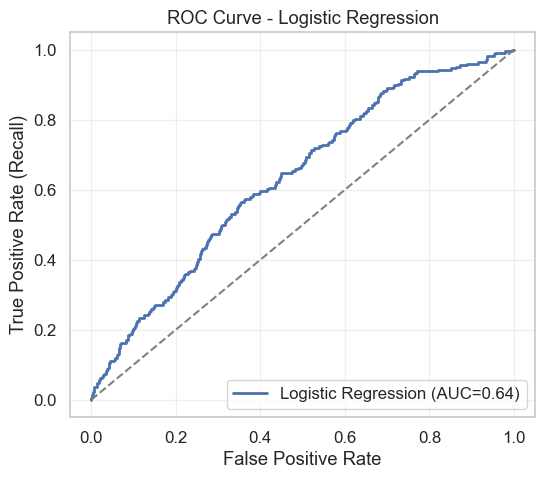

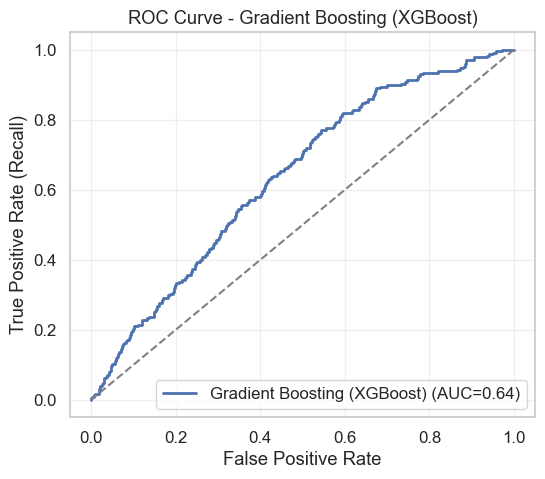

In [24]:
# ---------------------------------------------------------
# 5.2 ROC CURVES
# ---------------------------------------------------------

plot_roc_curve(y_valid, y_valid_prob_lr, model_name="Logistic Regression")
plot_roc_curve(y_valid, y_valid_prob_gb, model_name="Gradient Boosting (XGBoost)")

### 5.3 Precision-Recall Curves


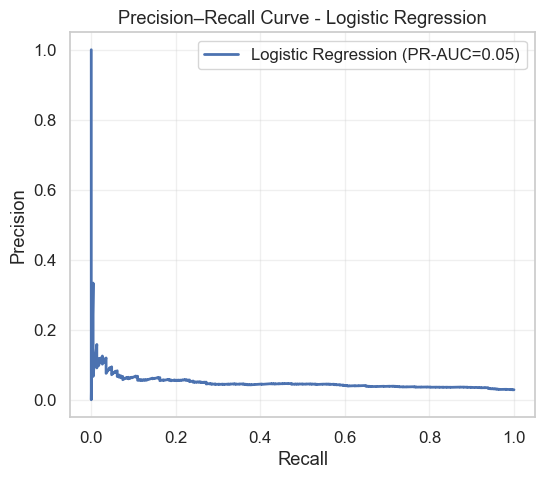

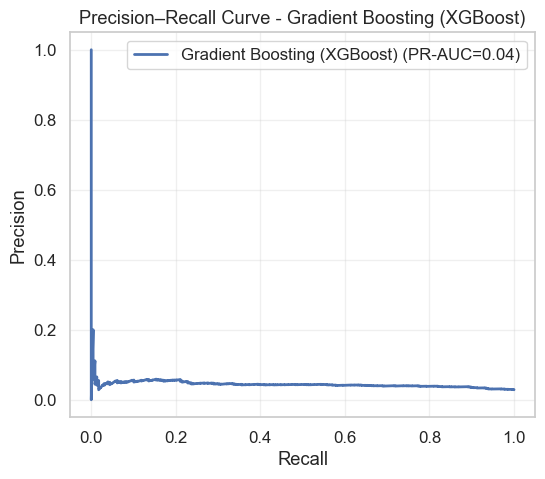


🔹 Logistic Regression Detailed Evaluation:

📊 Model Evaluation Summary
AUC: 0.6351 | KS: 0.2117 | Threshold: 0.50

Classification Report:
              precision    recall  f1-score      support
0              0.980508  0.621333  0.760652  7772.000000
1              0.042927  0.578947  0.079927   228.000000
accuracy       0.620125  0.620125  0.620125     0.620125
macro avg      0.511717  0.600140  0.420290  8000.000000
weighted avg   0.953787  0.620125  0.741251  8000.000000


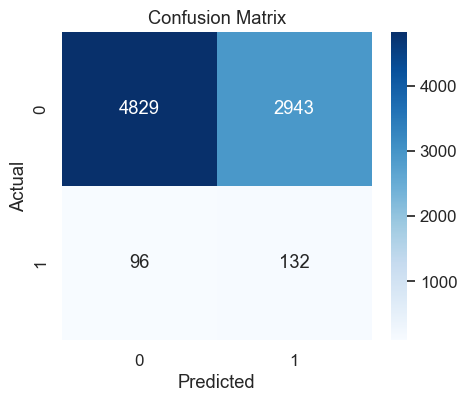


🔹 Gradient Boosting (XGBoost) Detailed Evaluation:

📊 Model Evaluation Summary
AUC: 0.6390 | KS: 0.2277 | Threshold: 0.54

Classification Report:
              precision    recall  f1-score      support
0              0.974899  0.899511  0.935689  7772.000000
1              0.057901  0.210526  0.090823   228.000000
accuracy       0.879875  0.879875  0.879875     0.879875
macro avg      0.516400  0.555019  0.513256  8000.000000
weighted avg   0.948764  0.879875  0.911610  8000.000000


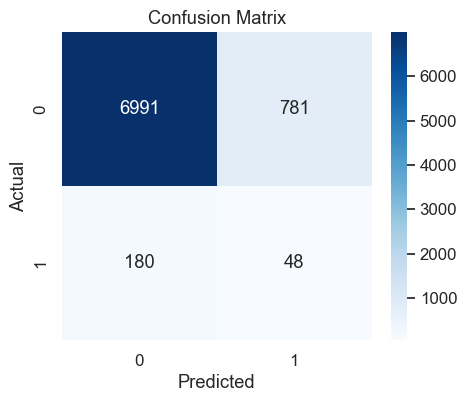

In [25]:
# ---------------------------------------------------------
# 5.3 PRECISION–RECALL CURVES
# ---------------------------------------------------------

plot_precision_recall_curve(y_valid, y_valid_prob_lr, model_name="Logistic Regression")
plot_precision_recall_curve(y_valid, y_valid_prob_gb, model_name="Gradient Boosting (XGBoost)")

#  DETAILED EVALUATION (OPTIONAL)
# ---------------------------------------------------------

print("\n🔹 Logistic Regression Detailed Evaluation:")
lr_eval = evaluate_model(y_valid, y_valid_prob_lr, threshold=0.5)

print("\n🔹 Gradient Boosting (XGBoost) Detailed Evaluation:")
gb_eval = evaluate_model(y_valid, y_valid_prob_gb, threshold=float(best_thresh))

## 6. Model Interpretation

### 6.1 Feature Importance


🔹 Extracting and Visualizing Feature Importance...



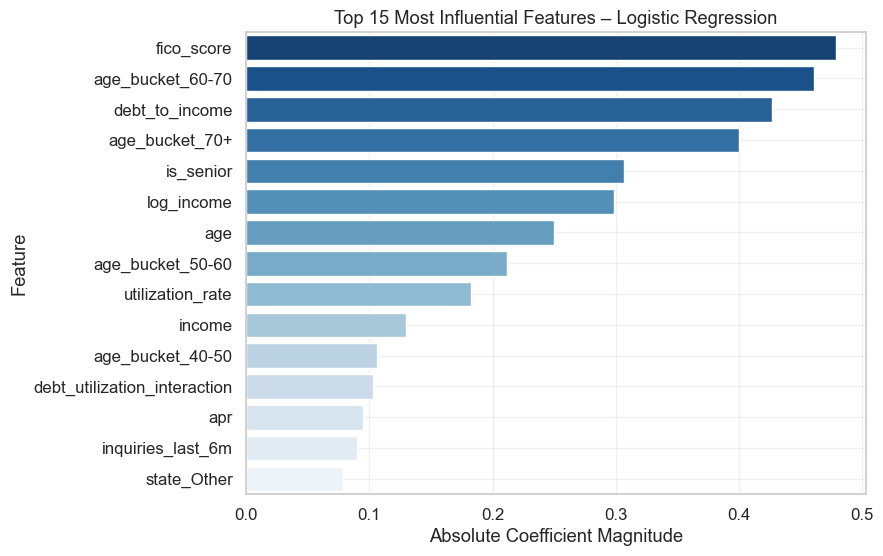


✅ Top Positive and Negative Drivers (Logistic Regression):
             Feature  Importance
0         fico_score   -0.479069
37  age_bucket_60-70    0.461204
2     debt_to_income    0.426501
38    age_bucket_70+    0.400113
20         is_senior   -0.306533
18        log_income   -0.298200
10               age   -0.249581
36  age_bucket_50-60    0.211909
4   utilization_rate    0.182694
1             income    0.129497
                           Feature  Importance
31                        state_NY   -0.015928
34                age_bucket_30-40    0.011578
24           product_type_Business    0.009927
27           product_type_Personal   -0.007737
3                  num_open_trades   -0.003810
19                 log_loan_amount    0.000948
21               is_online_channel    0.000000
11         fico_score_missing_flag    0.000000
12             income_missing_flag    0.000000
13  inquiries_last_6m_missing_flag    0.000000


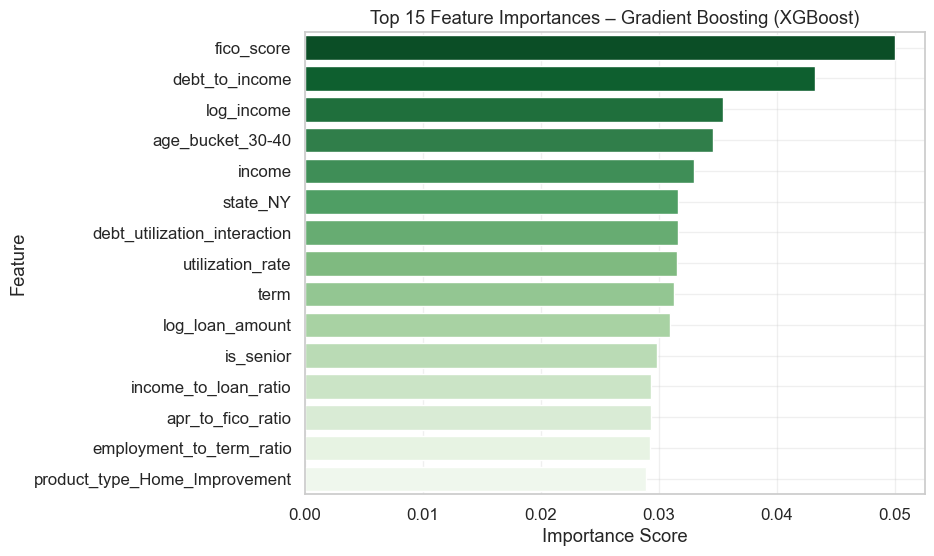


✅ Top 10 Important Features (XGBoost):
                         Feature  Importance
0                     fico_score    0.050071
2                 debt_to_income    0.043266
18                    log_income    0.035490
34              age_bucket_30-40    0.034620
1                         income    0.032967
31                      state_NY    0.031681
15  debt_utilization_interaction    0.031632
4               utilization_rate    0.031584
7                           term    0.031282
19               log_loan_amount    0.030947


In [26]:
# ---------------------------------------------------------
# 6.1 FEATURE IMPORTANCE
# ---------------------------------------------------------

print("🔹 Extracting and Visualizing Feature Importance...\n")

# ---------- LOGISTIC REGRESSION IMPORTANCE ----------
try:
    # Safely extract the classifier whether pipeline or standalone
    if hasattr(log_reg_model, "named_steps"):
        clf = log_reg_model.named_steps.get("clf", list(log_reg_model.named_steps.values())[-1])
    else:
        clf = log_reg_model

    if hasattr(clf, "coef_"):
        coef_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": clf.coef_[0]
        })
        coef_df["AbsImportance"] = coef_df["Importance"].abs()
        coef_df.sort_values(by="AbsImportance", ascending=False, inplace=True)

        plt.figure(figsize=(8, 6))
        sns.barplot(
            data=coef_df.head(15),
            x="AbsImportance",
            y="Feature",
            palette="Blues_r"
        )
        plt.title("Top 15 Most Influential Features – Logistic Regression")
        plt.xlabel("Absolute Coefficient Magnitude")
        plt.ylabel("Feature")
        plt.grid(alpha=0.3)
        plt.show()

        print("\n✅ Top Positive and Negative Drivers (Logistic Regression):")
        print(coef_df.head(10)[["Feature", "Importance"]])
        print(coef_df.tail(10)[["Feature", "Importance"]])
    else:
        print("⚠️ Logistic Regression model has no coefficients available.")

except Exception as e:
    print(f"⚠️ Logistic Regression importance extraction failed: {e}")


# ---------- GRADIENT BOOSTING / XGBOOST IMPORTANCE ----------
try:
    if hasattr(gb_model, "feature_importances_"):
        gb_importance_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": gb_model.feature_importances_
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8, 6))
        sns.barplot(
            data=gb_importance_df.head(15),
            x="Importance",
            y="Feature",
            palette="Greens_r"
        )
        plt.title("Top 15 Feature Importances – Gradient Boosting (XGBoost)")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.grid(alpha=0.3)
        plt.show()

        print("\n✅ Top 10 Important Features (XGBoost):")
        print(gb_importance_df.head(10))
    else:
        print("⚠️ No feature_importances_ attribute found for Gradient Boosting model.")

except Exception as e:
    print(f"⚠️ Gradient Boosting importance extraction failed: {e}")

### 6.2 Key Drivers of Default



🔍 Extracting Key Drivers of Default...



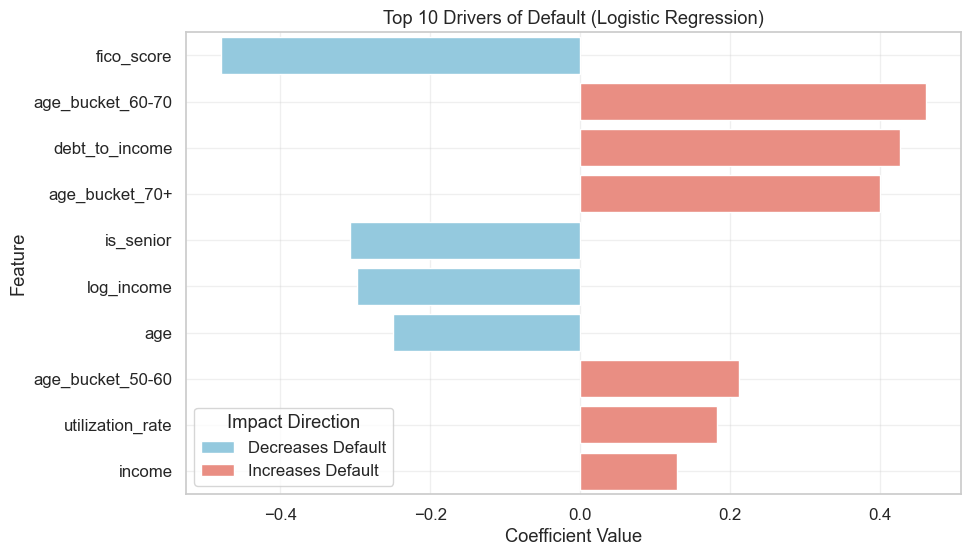

✅ Top 10 Key Drivers of Default (Logistic Regression):


,Feature,Coefficient,Direction
0,fico_score,-0.479069,Decreases Default
37,age_bucket_60-70,0.461204,Increases Default
2,debt_to_income,0.426501,Increases Default
38,age_bucket_70+,0.400113,Increases Default
20,is_senior,-0.306533,Decreases Default
18,log_income,-0.298200,Decreases Default
10,age,-0.249581,Decreases Default
36,age_bucket_50-60,0.211909,Increases Default
4,utilization_rate,0.182694,Increases Default
1,income,0.129497,Increases Default


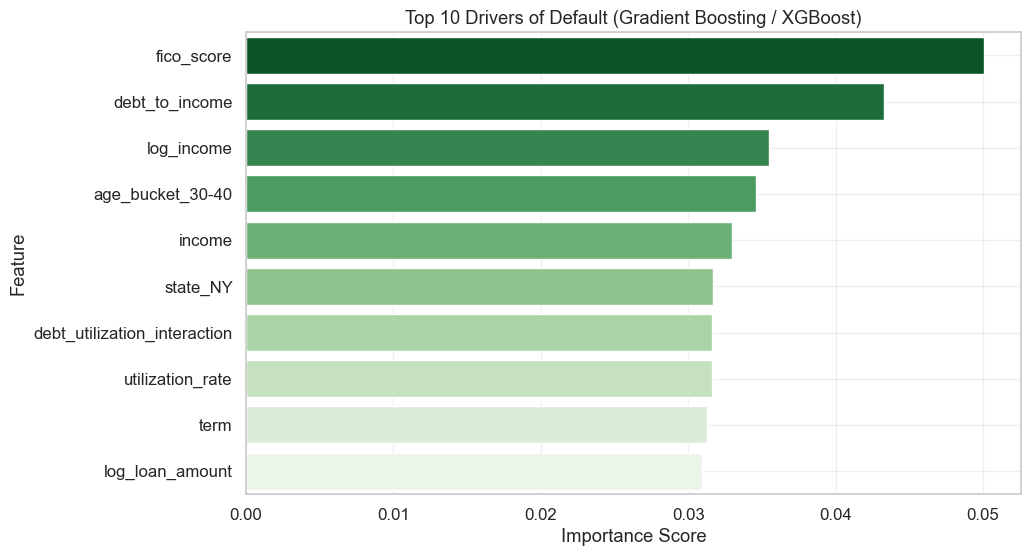

✅ Top 10 Key Drivers of Default (XGBoost):


,Feature,Importance
0,fico_score,0.050071
2,debt_to_income,0.043266
18,log_income,0.035490
34,age_bucket_30-40,0.034620
1,income,0.032967
31,state_NY,0.031681
15,debt_utilization_interaction,0.031632
4,utilization_rate,0.031584
7,term,0.031282
19,log_loan_amount,0.030947


In [27]:
# =========================================
# 6.2 KEY DRIVERS OF DEFAULT
# =========================================
print("\n🔍 Extracting Key Drivers of Default...\n")

# ---------- LOGISTIC REGRESSION KEY DRIVERS ----------
try:
    if hasattr(clf, "coef_"):
        coef_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Coefficient": clf.coef_[0]
        })
        coef_df["Direction"] = np.where(coef_df["Coefficient"] > 0, "Increases Default", "Decreases Default")
        coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
        top_drivers = coef_df.sort_values("AbsCoefficient", ascending=False).head(10)

        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=top_drivers,
            x="Coefficient",
            y="Feature",
            hue="Direction",
            dodge=False,
            palette={"Increases Default": "salmon", "Decreases Default": "skyblue"}
        )
        plt.title("Top 10 Drivers of Default (Logistic Regression)")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.legend(title="Impact Direction")
        plt.grid(alpha=0.3)
        plt.show()

        print("✅ Top 10 Key Drivers of Default (Logistic Regression):")
        display(top_drivers[["Feature", "Coefficient", "Direction"]])
    else:
        print("⚠️ No coefficients available for Logistic Regression key driver analysis.")

except Exception as e:
    print(f"⚠️ Could not extract Logistic Regression drivers: {e}")


# ---------- GRADIENT BOOSTING / XGBOOST KEY DRIVERS ----------
try:
    if hasattr(gb_model, "feature_importances_"):
        importances = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": gb_model.feature_importances_
        }).sort_values("Importance", ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=importances.head(10),
            x="Importance",
            y="Feature",
            palette="Greens_r"
        )
        plt.title("Top 10 Drivers of Default (Gradient Boosting / XGBoost)")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.grid(alpha=0.3)
        plt.show()

        print("✅ Top 10 Key Drivers of Default (XGBoost):")
        display(importances.head(10))
    else:
        print("⚠️ Gradient Boosting model does not expose feature_importances_.")

except Exception as e:
    print(f"⚠️ Could not extract XGBoost drivers: {e}")

## 7. Discussion & Next Steps

### 7.1 Model Assumptions

**Logistic Regression:**
- Assumes a linear relationship between the independent variables and the log-odds of the default probability.  
- Requires independence among predictors and limited multicollinearity.  
- Sensitive to outliers and scaling; works best when predictors are standardized.  
- Provides interpretable coefficients, useful for explaining credit-risk drivers.  

**Tree-Based Model (XGBoost):**
- Makes no assumptions about linearity or feature distributions.  
- Automatically captures nonlinear relationships and variable interactions.  
- Robust to multicollinearity and feature scaling.  
- Handles missing values internally and adapts to complex credit-behavior patterns.  

**Data Assumptions:**
- Historical borrower behavior is representative of future risk outcomes (stationarity).  
- Temporal splits reflect realistic pre-origination prediction scenarios to avoid future information leakage.  

---

### 7.2 Potential Data Leakage

**Prevented Leakage:**
- Removed variables highly correlated with the target, such as `loan_status`, `days_past_due_current`, `months_on_book`, and `sample_weight`.  
- These features reflected post-origination performance and could inflate predictive power.  

**Remaining Risks:**
- Temporal leakage from variables measured after loan origination (e.g., updated payment metrics).  
- Aggregated or derived features may embed forward-looking information.  
- Sampling bias if defaults are overrepresented relative to the natural portfolio distribution.  

By cleaning the data and enforcing temporal validation, the risk of leakage was minimized and model evaluation reflects real-world conditions.

---

### 7.3 Model Improvements

- **Feature Engineering:** Add new derived variables such as loan-to-income ratio, utilization interactions, payment ratios, and external credit-bureau indicators.  
- **Hyperparameter Tuning:** Use grid search or Bayesian optimization for learning rate, max depth, and feature sampling ratios.  
- **Ensemble Methods:** Combine linear (Logistic Regression) and nonlinear (XGBoost) models through stacking to improve robustness.  
- **Class Imbalance Handling:** Explore SMOTE, focal loss, or cost-sensitive learning to address the ~3% default rate.  
- **External Data Sources:** Integrate macroeconomic variables (e.g., unemployment, GDP) and behavioral features for better risk discrimination.  

---

### 7.4 Production Considerations

- **Model Monitoring:** Track AUC, KS, and PSI (Population Stability Index) over time to detect drift and degradation.  
- **Performance Degradation:** Implement scheduled retraining and recalibration triggers based on monitoring thresholds.  
- **Scalability:** Deploy XGBoost for distributed batch scoring; Logistic Regression can serve lightweight, real-time predictions.  
- **Interpretability Requirements:** Use Logistic Regression coefficients and SHAP values from XGBoost for explainability and compliance.  
- **Regulatory Compliance:** Ensure adherence to Fair Lending and Explainable AI requirements, maintaining transparency and auditability.  

---

## Summary

- **Best Performing Model:** XGBoost achieved slightly higher validation AUC (0.64) than Logistic Regression (0.63), benefiting from its ability to capture nonlinear interactions.  
- **Key Insights:** Lower FICO scores, higher debt-to-income ratios, and older age groups (60–70+) were key indicators of higher default risk.  
- **Recommendations:**  
  - Use XGBoost as the primary production model due to higher accuracy and robustness.  
  - Retain Logistic Regression as a benchmark and compliance-friendly challenger model.  
  - Continue improving data quality, feature richness, and monitoring processes for long-term model stability.  

---
